In [1]:
%pip install requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import json
import os
import json
import os



RSA_SIZE = 2048


DEFAULT_CURVE = "secp384r1"
FAST_CURVE = "secp256r1"
SUPPORTED_CURVES = [DEFAULT_CURVE, FAST_CURVE]

DIGEST_SHA384 = "sha384"
DIGEST_SHA256 = "sha256"

RSA_SIZE = 2048
# CCF network node
server="https://127.0.0.1:8000"

num_users = 4
# Getting Network metrices
url = server + "/app/api/metrics"

try:
    response = requests.get(url, verify='./workspace/sandbox_common/service_cert.pem')

    print("Status Code:", response.status_code)
    print("\nResponse Headers:")
    for header, value in response.headers.items():
        print(f"{header}: {value}")

    print("\nResponse Body:")
    try:
        # Attempt to parse JSON and print it in an indented format
        response_json = response.json()
        print(json.dumps(response_json, indent=4))
    except ValueError:
        # If response is not JSON, print as plain text
        print(response.text)

except requests.exceptions.RequestException as e:
    print("Error making request:", e)

Status Code: 200

Response Headers:
content-length: 347
content-type: application/json

Response Body:
{
    "metrics": [
        {
            "calls": 4,
            "errors": 0,
            "failures": 0,
            "method": "GET",
            "path": "api/metrics",
            "retries": 0
        },
        {
            "calls": 2,
            "errors": 0,
            "failures": 0,
            "method": "GET",
            "path": "commit",
            "retries": 0
        },
        {
            "calls": 3,
            "errors": 0,
            "failures": 0,
            "method": "POST",
            "path": "model/intial_model",
            "retries": 0
        },
        {
            "calls": 3,
            "errors": 0,
            "failures": 0,
            "method": "GET",
            "path": "status",
            "retries": 0
        }
    ]
}


In [3]:
%pip install matplotlib
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### CNN Model with Mnist Datasets

In [4]:
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL



def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights =deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None


def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []
def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id,round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)
  
    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")
def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    return history.history['loss']

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')
    

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
      "global_model": {
        "model_name": "CNNModel",
        "model_data": model_base64
      }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None
def flatten_weights(model):
    """Flatten the model weights"""
    flat_weights = []
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:
            flat_weights.append(weights[0].flatten())
    return np.concatenate(flat_weights)
def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights


def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights



# def serialize_weights(model):
#     """Serialize the model weights by flattening them"""
#     # flat_weights = flatten_weights(model)
#     local_model_weights = model.get_weights()
#     # Serialize the weights using numpy's tolist() method

    
#     serialized_weights = json.dumps(local_model_weights)
#     return serialized_weights
def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    # Get the model weights
    local_model_weights = model.get_weights()
    
    # Convert numpy arrays to lists
    serialized_weights = [arr.tolist() for arr in local_model_weights]
    
    # Serialize the weights using json.dumps
    serialized_weights_json = json.dumps(serialized_weights)
    
    return serialized_weights_json




def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
  

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data
            
            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")
        
        time.sleep(2)  # Delay before retrying
        attempts += 1
    
    raise Exception("Failed to download model after maximum retries.")
def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()
def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]
        
        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Conv2D):
                    # Check if it's a Conv2D layer
                    weights_shape = local_layers[i].get_weights()[0].shape
                    provided_weights_shape = global_model_weights[i][0].shape
                    print(f"Layer {local_layers[i].name} - Expected shape: {weights_shape}, Provided shape: {provided_weights_shape}")
                    
                    if weights_shape == provided_weights_shape:
                        local_layers[i].set_weights([global_model_weights[i][0], global_model_weights[i][1]])
                    else:
                        try:
                            reshaped_kernel_weights = np.reshape(global_model_weights[i][0], weights_shape)
                            local_layers[i].set_weights([reshaped_kernel_weights, global_model_weights[i][1]])
                        except ValueError as e:
                            print(f"Error reshaping weights for layer {local_layers[i].name}: {e}")
                elif isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                # Add similar checks for other layer types if needed
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")

2024-06-20 20:04:47.437456: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 20:04:47.738520: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 20:04:47.740229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 20:04:48.871603: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Experiment for Non CNN model with fashion MNIST dataset

In [5]:
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL


def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None


def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []


def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def aggregate_weights(model_id, round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)

    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")


def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=20):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    return history.history['loss']


def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')


def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
        "global_model": {
            "model_name": "FeedforwardModel",
            "model_data": model_base64
        }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None


def flatten_weights(model_weights):
    """Flatten the model weights"""
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)


def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights


def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights


def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights


def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")


def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data

            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")

        time.sleep(2)  # Delay before retrying
        attempts += 1

    raise Exception("Failed to download model after maximum retries.")


def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")


def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()


def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]

        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")


# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Split the dataset for two users
print("Splitting dataset for two users...")
split_index = int(len(X_train) / 2)
X_train_user0, X_train_user1 = np.split(X_train, [split_index])
y_train_user0, y_train_user1 = np.split(y_train, [split_index])

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, X_train_user0, y_train_user0, X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

num_rounds = 4  # Number of training rounds
user_losses = {0: [], 1: []}  # To track losses for each user

# Download the latest global model once for each client
global_model = download_model(
    "./workspace/sandbox_common/user0_cert.pem",
    "./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for both users
local_model_user0 = global_model
local_model_user1 = global_model

for round_no in range(1, num_rounds + 1):
    for user_id in range(2):  # Two users: 0 and 1
        # Train the local model on the user's data
        X_train_user = X_train_user0 if user_id == 0 else X_train_user1
        y_train_user = y_train_user0 if user_id == 0 else y_train_user1
        loss = train_model(local_model_user0 if user_id == 0 else local_model_user1,
                           X_train_user, y_train_user, X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_model_user0 if user_id == 0 else local_model_user1)
        # Upload model weights only if they are not empty
        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_model_user0
    )

print("Federated Learning Process Completed.")

# Plot loss graphs for each user
plot_loss(user_losses)
delete_temp_model_file()


Loading and preprocessing Fashion MNIST dataset...
4422102/4422102 [==============================] - 0s 0us/step
No temporary model file found at: temp_model.h5
Splitting dataset for two users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/20
938/938 [==============================] - 4s 3ms/step - loss: 7.3479 - accuracy: 0.6868 - val_loss: 1.1659 - val_accuracy: 0.6794
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.9768 - accuracy: 0.6996 - val_loss: 0.9624 - val_accuracy: 0.7076
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.7879 - accuracy: 0.7344 - val_loss: 0.8381 - val_accuracy: 0.7541
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.6869 - accuracy: 0.7703 - val_loss: 0.7969 - val_accuracy: 0.7298
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.6285 - accuracy: 0.7818 - val_loss: 0.6498 - val_accuracy: 0.7835
Epoch 6/20
938/938 [==

/home/aamar/Downloads/project/CCF_FL_Block/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training model for User 0, Round 1...
Epoch 1/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4536 - accuracy: 0.8471 - val_loss: 0.6744 - val_accuracy: 0.8110
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4387 - accuracy: 0.8514 - val_loss: 0.6069 - val_accuracy: 0.8116
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4482 - accuracy: 0.8500 - val_loss: 0.7011 - val_accuracy: 0.8089
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4473 - accuracy: 0.8472 - val_loss: 0.6448 - val_accuracy: 0.8161
Epoch 5/20
938/938 [==============================] - 2s 3ms/step - loss: 0.4400 - accuracy: 0.8509 - val_loss: 0.6499 - val_accuracy: 0.8044
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4350 - accuracy: 0.8543 - val_loss: 0.7023 - val_accuracy: 0.8024
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4267 - accuracy: 0.8558 - val_loss

KeyboardInterrupt: 

## centerlize traning

Epoch 1/10
469/469 [==============================] - 21s 42ms/step - loss: 1.6606 - accuracy: 0.4348 - val_loss: 0.7556 - val_accuracy: 0.7210
Epoch 2/10
469/469 [==============================] - 20s 42ms/step - loss: 1.0660 - accuracy: 0.6094 - val_loss: 0.6632 - val_accuracy: 0.7462
Epoch 3/10
469/469 [==============================] - 20s 43ms/step - loss: 0.9334 - accuracy: 0.6540 - val_loss: 0.6184 - val_accuracy: 0.7648
Epoch 4/10
469/469 [==============================] - 20s 43ms/step - loss: 0.8664 - accuracy: 0.6756 - val_loss: 0.6001 - val_accuracy: 0.7716
Epoch 5/10
469/469 [==============================] - 20s 42ms/step - loss: 0.8108 - accuracy: 0.6949 - val_loss: 0.5757 - val_accuracy: 0.7829
Epoch 6/10
469/469 [==============================] - 20s 43ms/step - loss: 0.7791 - accuracy: 0.7078 - val_loss: 0.5637 - val_accuracy: 0.7916
Epoch 7/10
469/469 [==============================] - 20s 42ms/step - loss: 0.7504 - accuracy: 0.7173 - val_loss: 0.5551 - val_accuracy:

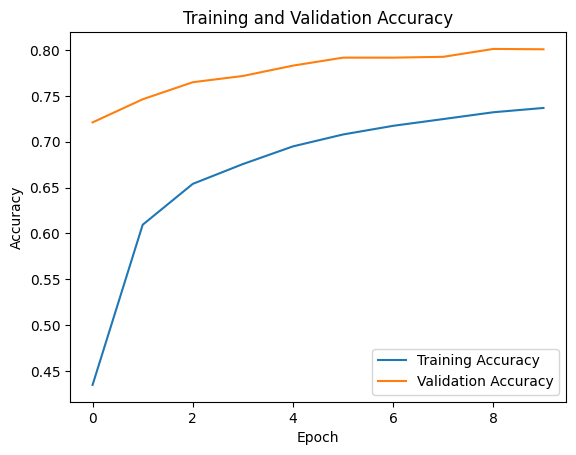

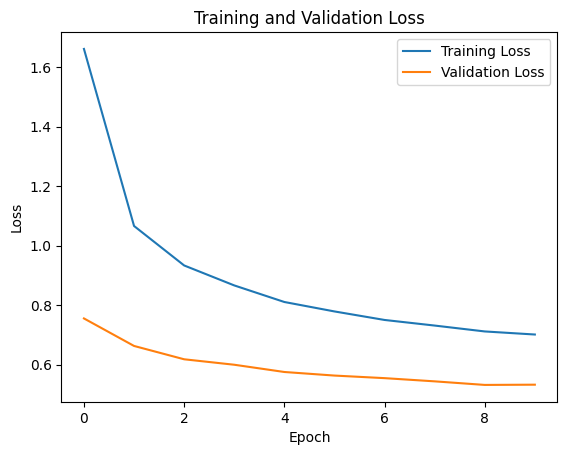

313/313 [==============================] - 1s 2ms/step - loss: 0.5331 - accuracy: 0.8007
Test Accuracy: 0.8007000088691711
313/313 [==============================] - 1s 2ms/step


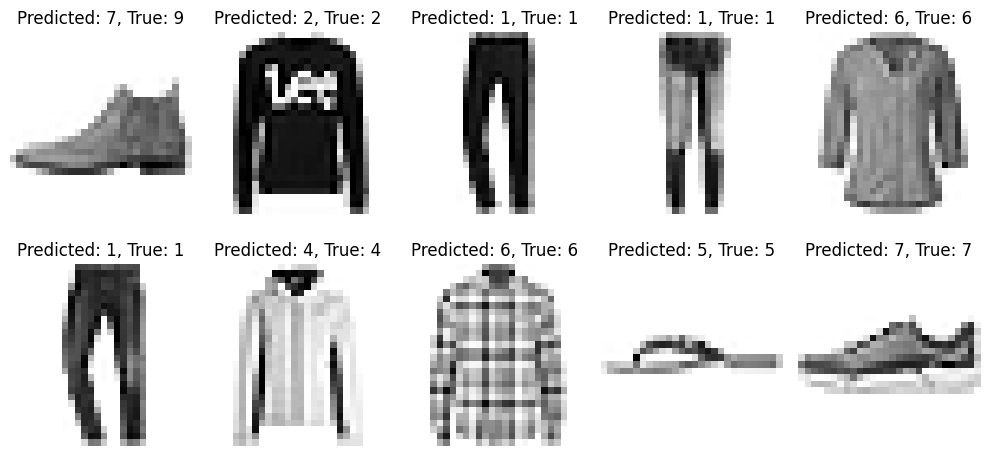

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Reshape and preprocess the data
train_images = tf.expand_dims(train_images, axis=-1)
train_images = tf.cast(train_images, tf.float32) / 255.0

test_images = tf.expand_dims(test_images, axis=-1)
test_images = tf.cast(test_images, tf.float32) / 255.0

# One-hot encode the labels
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    zoom_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=False,  
    fill_mode='nearest'  
)
datagen.fit(train_images)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model with validation split
history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
                    epochs=10, validation_data=(test_images, test_labels))

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on test images
predictions = model.predict(test_images)

# Display sample predictions in a single graph
plt.figure(figsize=(10, 5))
for i in range(10):
    predicted_class = tf.argmax(predictions[i]).numpy()
    true_class = tf.argmax(test_labels[i]).numpy()
    
    # Reshape the image
    image = tf.reshape(test_images[i], (28, 28))

    # Plot the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.title(f"Predicted: {predicted_class}, True: {true_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### implelmtion of LetNet-5 in centerlized machine learning

Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4847 - accuracy: 0.8189 - val_loss: 0.3961 - val_accuracy: 0.8548
Epoch 2/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3591 - accuracy: 0.8660 - val_loss: 0.3553 - val_accuracy: 0.8731
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3320 - accuracy: 0.8761 - val_loss: 0.3525 - val_accuracy: 0.8702
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3193 - accuracy: 0.8810 - val_loss: 0.3729 - val_accuracy: 0.8729
Epoch 5/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3085 - accuracy: 0.8867 - val_loss: 0.3802 - val_accuracy: 0.8631
Epoch 6/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2951 - accuracy: 0.8913 - val_loss: 0.3532 - val_accuracy: 0.8815
Epoch 7/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2920 - accuracy: 0.8927 - val_loss: 0.3643 -

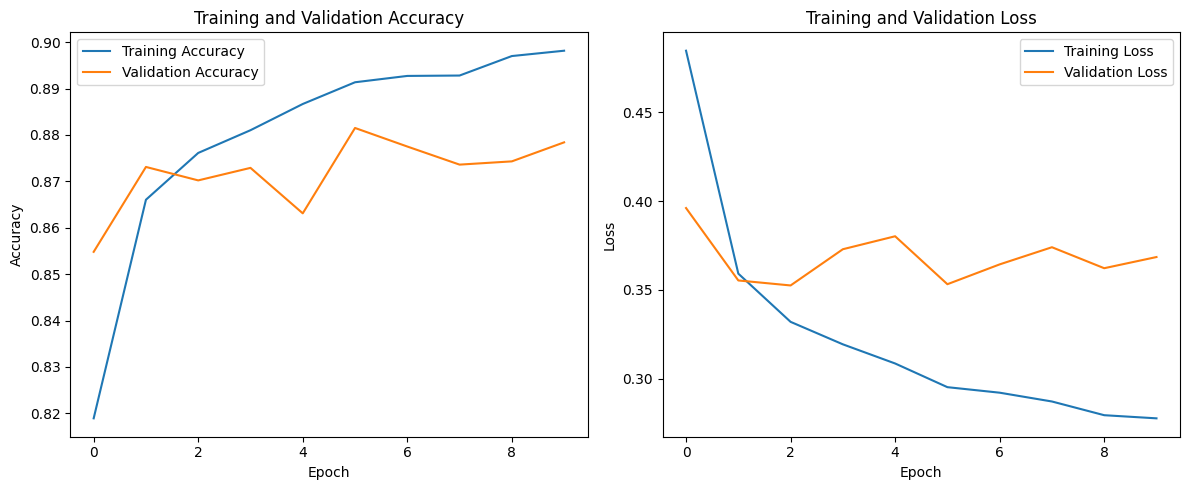

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Preprocess the data
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Define the LeNet-5 model
model = tf.keras.Sequential([
    # First Layer (C1)
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), padding='valid'),
    
    # Second Layer (S2)
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    # Third Layer (C3)
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu', padding='valid'),
    
    # Fourth Layer (S4)
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    # Flatten layer
    layers.Flatten(),
    
    # Fifth Layer (C5)
    layers.Dense(120, activation='relu'),
    
    # Sixth Layer (F6)
    layers.Dense(84, activation='relu'),
    
    # Output Layer
    layers.Dense(10, activation='softmax')
])

# Compile the model with specified learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")

# Predict labels
y_pred = model.predict(test_images)
y_pred = tf.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to integers
y_true = tf.argmax(test_labels, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


MNIST dataset


Epoch 1/10
1875/1875 [==============================] - 22s 11ms/step - loss: 0.2427 - accuracy: 0.9254 - val_loss: 0.1563 - val_accuracy: 0.9537
Epoch 2/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1507 - accuracy: 0.9539 - val_loss: 0.1225 - val_accuracy: 0.9637
Epoch 3/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1299 - accuracy: 0.9606 - val_loss: 0.1120 - val_accuracy: 0.9664
Epoch 4/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1200 - accuracy: 0.9634 - val_loss: 0.1152 - val_accuracy: 0.9647
Epoch 5/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1142 - accuracy: 0.9663 - val_loss: 0.0920 - val_accuracy: 0.9714
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1124 - accuracy: 0.9662 - val_loss: 0.0958 - val_accuracy: 0.9702
Epoch 7/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1073 - accuracy: 0.9681 - val_loss: 0.0959 -

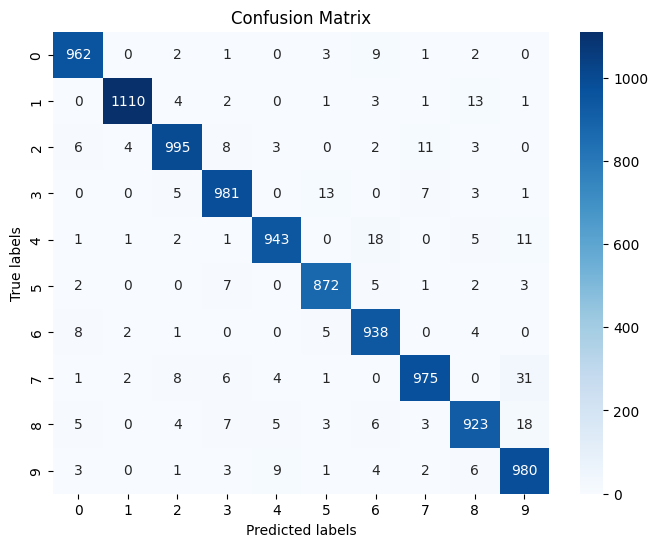

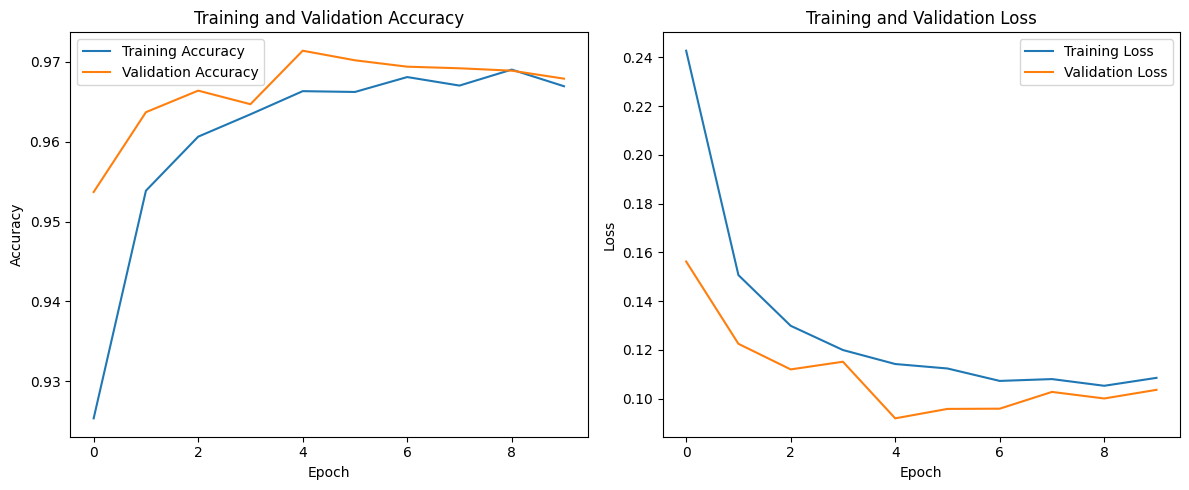

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Define the LeNet-5 model in TensorFlow/Keras
class LeNet5(tf.keras.Model):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = layers.Conv2D(6, kernel_size=(5, 5), activation='tanh', padding='valid')
        self.pool1 = layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')

        self.conv2 = layers.Conv2D(16, kernel_size=(5, 5), activation='tanh', padding='same')
        self.pool2 = layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')

        self.conv3 = layers.Conv2D(120, kernel_size=(5, 5), activation='tanh', padding='valid')
        self.flatten = layers.Flatten()

        self.fc1 = layers.Dense(84, activation='tanh')
        self.fc2 = layers.Dense(10, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = LeNet5()

# Compile the model with specified learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")

# Predict labels
y_pred = model.predict(test_images)
y_pred = tf.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to integers
y_true = tf.argmax(test_labels, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


simple fl

Loading and preprocessing Fashion MNIST dataset...
Deleted temporary model file: temp_model.h5
Splitting dataset for two users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
938/938 [==============================] - 3s 3ms/step - loss: 5.5135 - accuracy: 0.6670 - val_loss: 0.9864 - val_accuracy: 0.6718
Epoch 2/2
938/938 [==============================] - 3s 3ms/step - loss: 0.8369 - accuracy: 0.6959 - val_loss: 0.8497 - val_accuracy: 0.7150
Serializing the model...
Uploading initial global model...
Initial global model 'FeedforwardModel' (ID: 5) uploaded successfully.
Attempting to download model for User 0, Round 0, Attempt 1...
Training model for User 0, Round 1...
Epoch 1/2
938/938 [==============================] - 3s 3ms/step - loss: 0.7334 - accuracy: 0.7172 - val_loss: 0.7771 - val_accuracy: 0.7556
Epoch 2/2
938/938 [==============================] - 3s 3ms/step - loss: 0.6792 - accuracy: 0.7404 - val_loss: 0.6930 - val_accuracy: 0.7497
Uplo

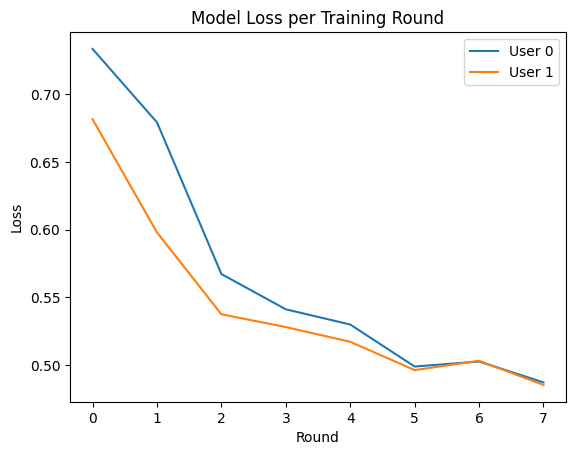

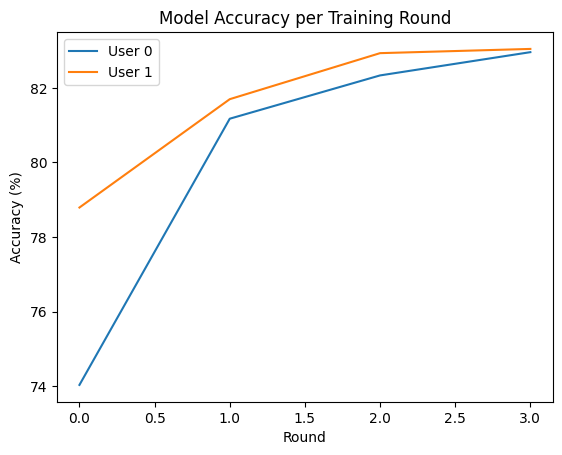

Deleted temporary model file: temp_model.h5


In [12]:
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL

def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None

def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []

def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)

    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")

def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    loss = history.history['loss']
    accuracy = history.history['accuracy'][-1] * 100
    return loss, accuracy

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
        "global_model": {
            "model_name": "FeedforwardModel",
            "model_data": model_base64
        }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None

def flatten_weights(model_weights):
    """Flatten the model weights"""
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)

def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights

def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights

def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights

def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data

            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")

        time.sleep(2)  # Delay before retrying
        attempts += 1

    raise Exception("Failed to download model after maximum retries.")

def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def plot_accuracy(user_accuracies):
    for user_id, accuracies in user_accuracies.items():
        plt.plot(accuracies, label=f'User {user_id}')
    plt.title('Model Accuracy per Training Round')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]

        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")

# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Split the dataset for two users
print("Splitting dataset for two users...")
split_index = int(len(X_train) / 2)
X_train_user0, X_train_user1 = np.split(X_train, [split_index])
y_train_user0, y_train_user1 = np.split(y_train, [split_index])

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, X_train_user0, y_train_user0, X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

num_rounds = 4  # Number of training rounds
user_losses = {0: [], 1: []}  # To track losses for each user
user_accuracies = {0: [], 1: []}  # To track accuracies for each user

# Download the latest global model once for each client
global_model = download_model(
    "./workspace/sandbox_common/user0_cert.pem",
    "./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for both users
local_model_user0 = global_model
local_model_user1 = global_model

for round_no in range(1, num_rounds + 1):
    for user_id in range(2):  # Two users: 0 and 1
        # Train the local model on the user's data
        X_train_user = X_train_user0 if user_id == 0 else X_train_user1
        y_train_user = y_train_user0 if user_id == 0 else y_train_user1
        loss, accuracy = train_model(local_model_user0 if user_id == 0 else local_model_user1,
                           X_train_user, y_train_user, X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)
        user_accuracies[user_id].append(accuracy)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_model_user0 if user_id == 0 else local_model_user1)
        # Upload model weights only if they are not empty
        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_model_user0
    )

print("Federated Learning Process Completed.")

# Plot loss and accuracy graphs for each user
plot_loss(user_losses)
plot_accuracy(user_accuracies)

delete_temp_model_file()


Loading and preprocessing Fashion MNIST dataset...
No temporary model file found at: temp_model.h5
Splitting dataset for two users...
Initializing the LeNet-5 model...
Training model for User 0, Round 0...
Epoch 1/10
938/938 [==============================] - 13s 13ms/step - loss: 0.4973 - accuracy: 0.8182 - val_loss: 0.4061 - val_accuracy: 0.8519
Epoch 2/10
938/938 [==============================] - 11s 12ms/step - loss: 0.3712 - accuracy: 0.8614 - val_loss: 0.4129 - val_accuracy: 0.8512
Epoch 3/10
938/938 [==============================] - 11s 12ms/step - loss: 0.3289 - accuracy: 0.8794 - val_loss: 0.3687 - val_accuracy: 0.8651
Epoch 4/10
938/938 [==============================] - 12s 12ms/step - loss: 0.3084 - accuracy: 0.8855 - val_loss: 0.3399 - val_accuracy: 0.8738
Epoch 5/10
938/938 [==============================] - 11s 12ms/step - loss: 0.2876 - accuracy: 0.8930 - val_loss: 0.3357 - val_accuracy: 0.8772
Epoch 6/10
938/938 [==============================] - 11s 12ms/step - loss

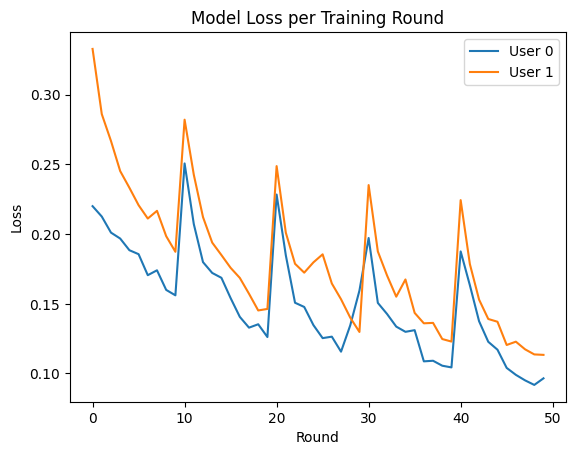

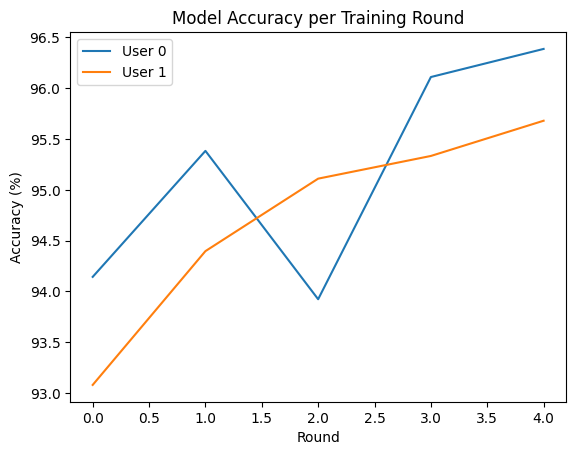

Deleted temporary model file: temp_model.h5


## Experiment with Dynamic list of user and also with random client selection


Loading and preprocessing Fashion MNIST dataset...
No temporary model file found at: temp_model.h5
Splitting dataset for 4 users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 9.2297 - accuracy: 0.6681 - val_loss: 1.4851 - val_accuracy: 0.6301
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 1.0423 - accuracy: 0.6781 - val_loss: 1.1035 - val_accuracy: 0.6894
Serializing the model...
Uploading initial global model...
Initial global model 'FeedforwardModel' (ID: 3) uploaded successfully.
Attempting to download model for User 0, Round 0, Attempt 1...
Training model for User 0, Round 1...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 0.8292 - accuracy: 0.6964 - val_loss: 1.0222 - val_accuracy: 0.6495
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 0.7505 - accuracy: 0.7077 - val_loss: 0.8699 - val_accuracy: 0.6804
Up

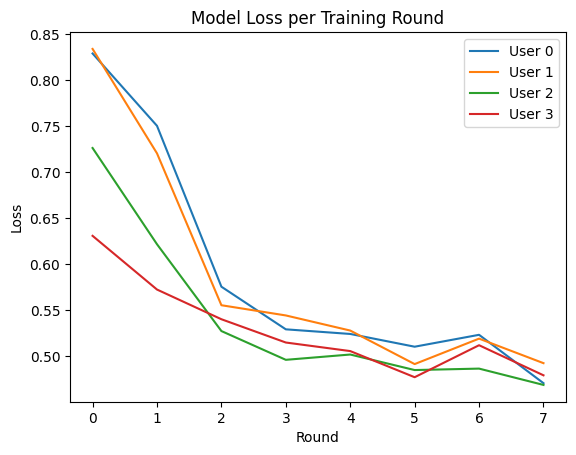

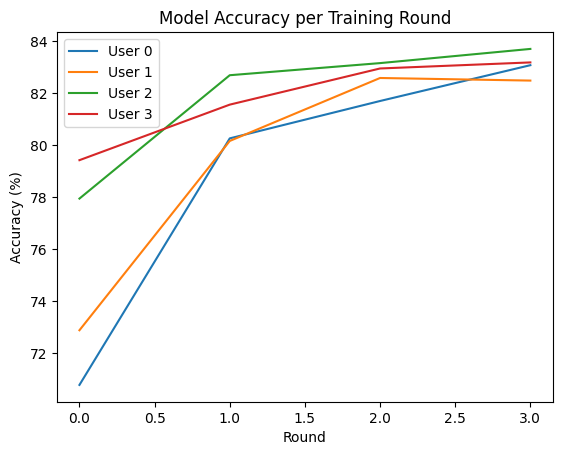

Deleted temporary model file: temp_model.h5


In [ ]:
import os
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL
num_users = 4  # Set the number of users

def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None

def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []

def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)

    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")

def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    loss = history.history['loss']
    accuracy = history.history['accuracy'][-1] * 100
    return loss, accuracy

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
        "global_model": {
            "model_name": "FeedforwardModel",
            "model_data": model_base64
        }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None

def flatten_weights(model_weights):
    """Flatten the model weights"""
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)

def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights

def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights

def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights

def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data

            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")

        time.sleep(2)  # Delay before retrying
        attempts += 1

    raise Exception("Failed to download model after maximum retries.")

def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def plot_accuracy(user_accuracies):
    for user_id, accuracies in user_accuracies.items():
        plt.plot(accuracies, label=f'User {user_id}')
    plt.title('Model Accuracy per Training Round')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]

        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")

# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Split the dataset for the specified number of users
print(f"Splitting dataset for {num_users} users...")
split_indices = np.linspace(0, len(X_train), num_users + 1, dtype=int)
user_data = [(X_train[start:end], y_train[start:end]) for start, end in zip(split_indices[:-1], split_indices[1:])]

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, user_data[0][0], user_data[0][1], X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

num_rounds = 4  # Number of training rounds
user_losses = {user_id: [] for user_id in range(num_users)}  # To track losses for each user
user_accuracies = {user_id: [] for user_id in range(num_users)}  # To track accuracies for each user

# Download the latest global model once for each client
global_model = download_model(
    f"./workspace/sandbox_common/user0_cert.pem",
    f"./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for all users
local_models = [global_model] * num_users

for round_no in range(1, num_rounds + 1):
    for user_id in range(num_users):
        # Train the local model on the user's data
        loss, accuracy = train_model(local_models[user_id], user_data[user_id][0], user_data[user_id][1], X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)
        user_accuracies[user_id].append(accuracy)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_models[user_id])
        # Upload model weights only if they are not empty
        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_models[0]  # Use any local model to update weights
    )

print("Federated Learning Process Completed.")

# Plot loss and accuracy graphs for each user
plot_loss(user_losses)
plot_accuracy(user_accuracies)

delete_temp_model_file()


Loading and preprocessing Fashion MNIST dataset...
No temporary model file found at: temp_model.h5
Splitting dataset for 4 users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 8.6952 - accuracy: 0.6488 - val_loss: 1.4680 - val_accuracy: 0.6132
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 1.1617 - accuracy: 0.6715 - val_loss: 1.1967 - val_accuracy: 0.6497
Serializing the model...
Uploading initial global model...
Initial global model 'FeedforwardModel' (ID: 4) uploaded successfully.
Attempting to download model for User 0, Round 0, Attempt 1...
Training model for User 3, Round 1...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 0.9565 - accuracy: 0.6990 - val_loss: 0.9274 - val_accuracy: 0.7012
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 0.7663 - accuracy: 0.7379 - val_loss: 0.8030 - val_accuracy: 0.7410
Up

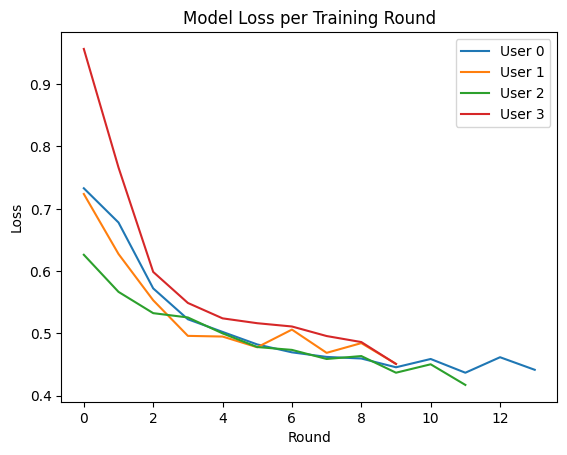

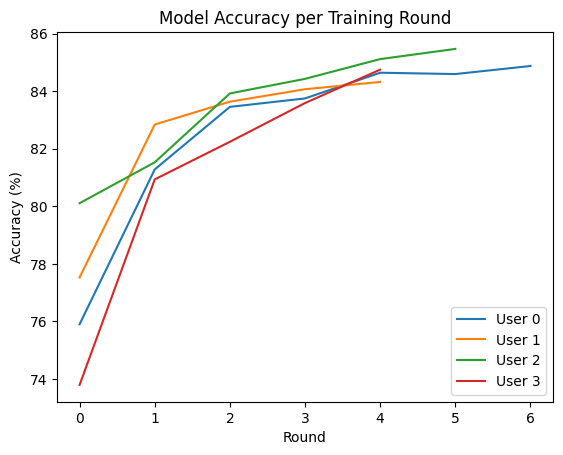

Deleted temporary model file: temp_model.h5


In [ ]:
import os
import numpy as np
import requests
import json
import base64
import time
import random
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL
num_users = 4  # Set the number of users
num_rounds = 8  # Increase the number of training rounds

def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None

def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []

def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)

    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")

def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    loss = history.history['loss']
    accuracy = history.history['accuracy'][-1] * 100
    return loss, accuracy

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
        "global_model": {
            "model_name": "FeedforwardModel",
            "model_data": model_base64
        }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None

def flatten_weights(model_weights):
    """Flatten the model weights"""
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)

def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights

def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights

def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights

def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data

            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")

        time.sleep(2)  # Delay before retrying
        attempts += 1

    raise Exception("Failed to download model after maximum retries.")

def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss(user_losses):
    for user_id, losses in user_losses.items():
        plt.plot(losses, label=f'User {user_id}')
    plt.title('Model Loss per Training Round')
    plt.ylabel('Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def plot_accuracy(user_accuracies):
    for user_id, accuracies in user_accuracies.items():
        plt.plot(accuracies, label=f'User {user_id}')
    plt.title('Model Accuracy per Training Round')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Round')
    plt.legend()
    plt.show()

def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]

        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")

# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Split the dataset for the specified number of users
print(f"Splitting dataset for {num_users} users...")
split_indices = np.linspace(0, len(X_train), num_users + 1, dtype=int)
user_data = [(X_train[start:end], y_train[start:end]) for start, end in zip(split_indices[:-1], split_indices[1:])]

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, user_data[0][0], user_data[0][1], X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

user_losses = {user_id: [] for user_id in range(num_users)}  # To track losses for each user
user_accuracies = {user_id: [] for user_id in range(num_users)}  # To track accuracies for each user

# Download the latest global model once for each client
global_model = download_model(
    f"./workspace/sandbox_common/user0_cert.pem",
    f"./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for all users
local_models = [global_model] * num_users

for round_no in range(1, num_rounds + 1):
    # Randomly choose the number of clients for this round
    num_clients_this_round = random.randint(1, num_users)
    participating_clients = random.sample(range(num_users), num_clients_this_round)

    for user_id in participating_clients:
        # Train the local model on the user's data
        loss, accuracy = train_model(local_models[user_id], user_data[user_id][0], user_data[user_id][1], X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)
        user_accuracies[user_id].append(accuracy)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_models[user_id])
        # Upload model weights only if they are not empty
        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_models[0]  # Use any local model to update weights
    )

print("Federated Learning Process Completed.")

# Plot loss and accuracy graphs for each user
plot_loss(user_losses)
plot_accuracy(user_accuracies)

delete_temp_model_file()


Loading and preprocessing Fashion MNIST dataset...
No temporary model file found at: temp_model.h5
Splitting dataset for 4 users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 9.3469 - accuracy: 0.6585 - val_loss: 1.1690 - val_accuracy: 0.6489
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 0.9509 - accuracy: 0.6901 - val_loss: 0.9031 - val_accuracy: 0.6822
Serializing the model...
Uploading initial global model...
Initial global model 'FeedforwardModel' (ID: 5) uploaded successfully.
Attempting to download model for User 0, Round 0, Attempt 1...
Training model for User 2, Round 1...
Epoch 1/2
469/469 [==============================] - 2s 4ms/step - loss: 0.8136 - accuracy: 0.7127 - val_loss: 0.7739 - val_accuracy: 0.7180
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 0.6906 - accuracy: 0.7317 - val_loss: 0.7156 - val_accuracy: 0.7177
Up

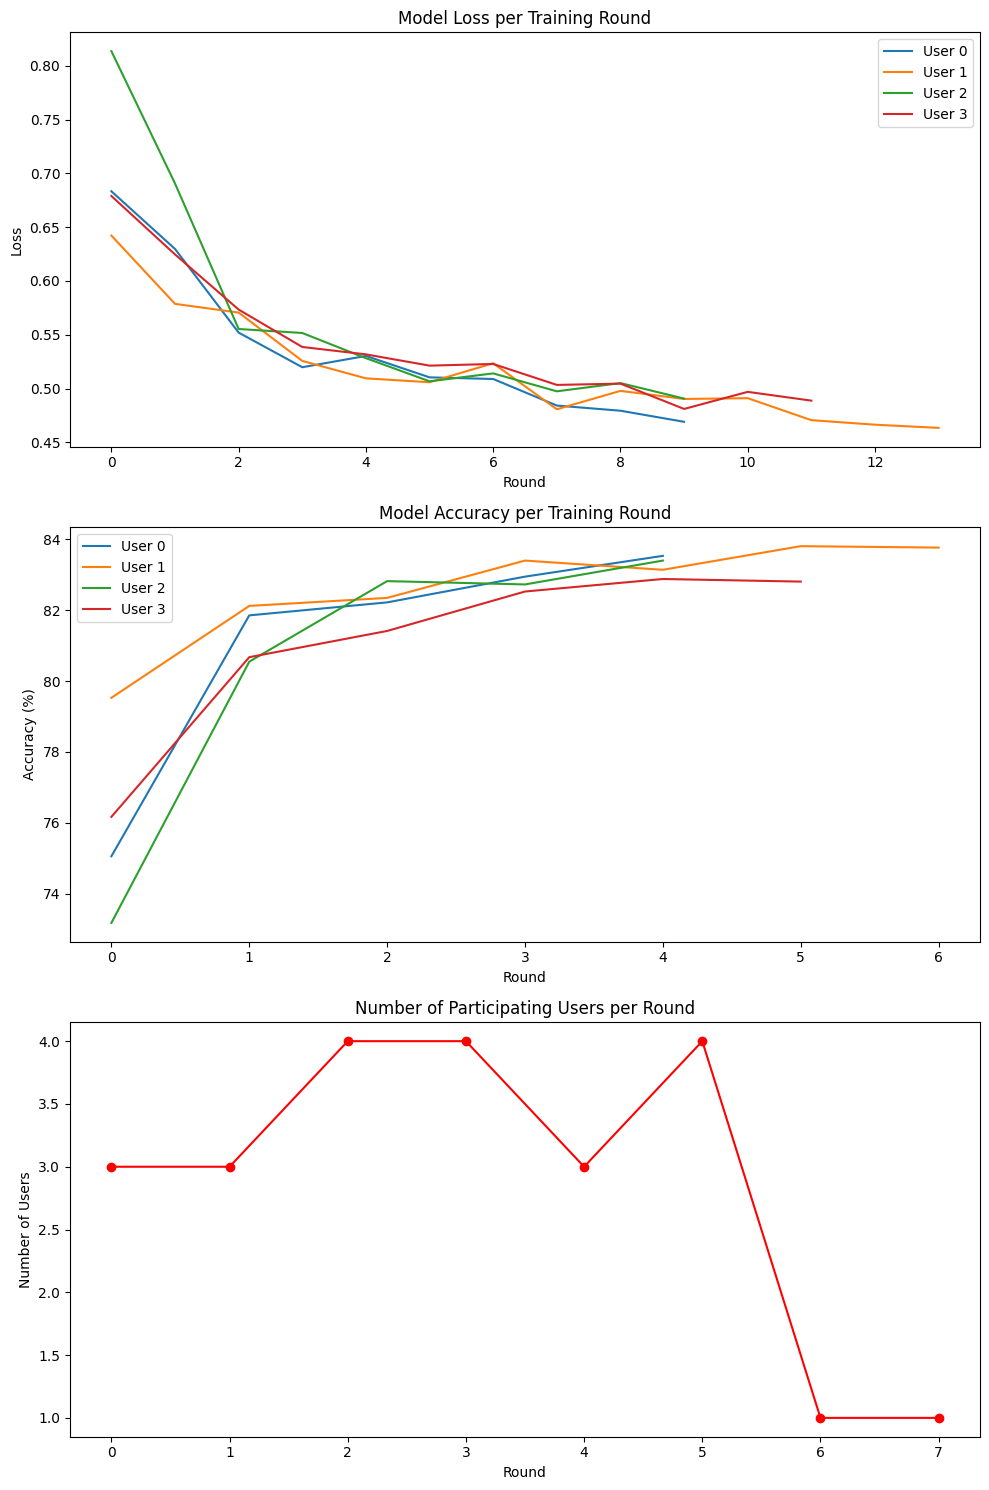

Deleted temporary model file: temp_model.h5


In [ ]:
import os
import numpy as np
import requests
import json
import base64
import time
import random
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL
num_users = 4  # Set the number of users
num_rounds = 8  # Increase the number of training rounds

def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None

def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []

def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, round_no, user_cert, user_key):
    print("Aggregating weights for model:", model_id)

    response = requests.put(
        url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key)
    )
    if response.status_code == 200:
        print("Aggregation successful for model:", model_id)
    else:
        raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")

def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=2):
    print(f"Training model for User {user_id}, Round {round_no}...")
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
    loss = history.history['loss']
    accuracy = history.history['accuracy'][-1] * 100
    return loss, accuracy

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

def upload_initial_model(model_base64, user_cert, user_key):
    print("Uploading initial global model...")
    payload = {
        "global_model": {
            "model_name": "FeedforwardModel",
            "model_data": model_base64
        }
    }
    response = requests.post(
        url=f"{server}/app/model/intial_model",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )

    if response.status_code == 200:
        model_data = response.json()
        model_id = model_data.get("model_id")
        model_name = model_data.get("model_name")
        print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
        return model_id
    else:
        print(f"Failed to upload initial model. Status code: {response.status_code}")
        return None

def flatten_weights(model_weights):
    """Flatten the model weights"""
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)

def deserialize_weights(serialized_weights, model):
    """Deserialize the flattened weights and return them without updating the model"""
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights

def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    # Convert the list of arrays to a NumPy array
    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights

def serialize_weights(model):
    """Serialize the model weights by flattening them"""
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights

def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    """ Upload only the model weights """
    print(f"Uploading model weights for Round {round_no}...")
    payload = {
        "model_id": model_id,
        "weights_json": model_weights_base64,
        "round_no": round_no
    }
    response = requests.post(
        url=f"{server}/app/model/upload/local_model_weights",
        verify="./workspace/sandbox_common/service_cert.pem",
        cert=(user_cert, user_key),
        json=payload
    )
    print(response.text)
    if response:
        print(f"Model weights uploaded successfully for Round {round_no}.")
    else:
        raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
        response = requests.get(
            url=f"{server}/app/model/download/global?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )

        if response.status_code == 200:
            model_data = response.json().get("model_details", {})
            model_base64 = model_data

            if model_base64:
                with open('temp_model.h5', 'wb') as file:
                    file.write(base64.b64decode(model_base64))
                return load_model('temp_model.h5')
            else:
                print("Model data not found in response, retrying...")
        else:
            print(f"Failed to download model. Status code: {response.status_code}, retrying...")

        time.sleep(2)  # Delay before retrying
        attempts += 1

    raise Exception("Failed to download model after maximum retries.")

def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss_and_accuracy(user_losses, user_accuracies, num_participating_users):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    for user_id, losses in user_losses.items():
        ax1.plot(losses, label=f'User {user_id}')

    ax1.set_title('Model Loss per Training Round')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Round')
    ax1.legend()

    for user_id, accuracies in user_accuracies.items():
        ax2.plot(accuracies, label=f'User {user_id}')

    ax2.set_title('Model Accuracy per Training Round')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_xlabel('Round')
    ax2.legend()

    ax3.plot(num_participating_users, marker='o', linestyle='-', color='r')
    ax3.set_title('Number of Participating Users per Round')
    ax3.set_ylabel('Number of Users')
    ax3.set_xlabel('Round')

    plt.tight_layout()
    plt.show()

def update_local_model(local_model, global_model_weights):
    if global_model_weights:
        global_model_weights = [np.array(w) for w in global_model_weights]

        # Get the layers in the local model
        local_layers = local_model.layers
        print(f"Local model layers: {local_layers}")
        print(f"Global model shape: {len(global_model_weights)}")
        # Set weights for each layer individually
        for i in range(len(local_layers)):
            if i < len(global_model_weights):
                if isinstance(local_layers[i], Dense):
                    # Check if it's a Dense layer
                    local_layers[i].set_weights(global_model_weights[i])
                else:
                    # Skip setting weights for layers without trainable weights
                    print(f"Skipped setting weights for layer {local_layers[i].name}: No trainable weights")
            else:
                print(f"Warning: No weights provided for layer {local_layers[i].name}")

        print("Global model weights updated for the local model.")
    else:
        print("No global model weights provided.")

# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Split the dataset for the specified number of users
print(f"Splitting dataset for {num_users} users...")
split_indices = np.linspace(0, len(X_train), num_users + 1, dtype=int)
user_data = [(X_train[start:end], y_train[start:end]) for start, end in zip(split_indices[:-1], split_indices[1:])]

# Initialize and train the global model (User 0)
global_model = create_model()
train_model(global_model, user_data[0][0], user_data[0][1], X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)

initial_model_id = upload_initial_model(model_base64, f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

user_losses = {user_id: [] for user_id in range(num_users)}  # To track losses for each user
user_accuracies = {user_id: [] for user_id in range(num_users)}  # To track accuracies for each user
num_participating_users = []  # To track the number of participating users in each round

# Download the latest global model once for each client
global_model = download_model(
    f"./workspace/sandbox_common/user0_cert.pem",
    f"./workspace/sandbox_common/user0_privk.pem",
    user_id=0, round_no=0, model_id=initial_model_id
)

# Initialize the local models for all users
local_models = [global_model] * num_users

for round_no in range(1, num_rounds + 1):
    # Randomly choose the number of clients for this round
    num_clients_this_round = random.randint(1, num_users)
    participating_clients = random.sample(range(num_users), num_clients_this_round)
    num_participating_users.append(num_clients_this_round)

    for user_id in participating_clients:
        # Train the local model on the user's data
        loss, accuracy = train_model(local_models[user_id], user_data[user_id][0], user_data[user_id][1], X_test, y_test, user_id, round_no)
        user_losses[user_id].extend(loss)
        user_accuracies[user_id].append(accuracy)

        # Serialize and upload the updated model weights for the current round
        local_serialize_weights = serialize_weights(local_models[user_id])
        # Upload model weights only if they are not empty
        if local_serialize_weights:
            upload_model_weights(local_serialize_weights, f"./workspace/sandbox_common/user{user_id}_cert.pem",
                                 f"./workspace/sandbox_common/user{user_id}_privk.pem", round_no, model_id=initial_model_id)
        else:
            print("Model weights are empty, skipping upload...")

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        f"./workspace/sandbox_common/user0_cert.pem", f"./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=local_models[0]  # Use any local model to update weights
    )

print("Federated Learning Process Completed.")

# Plot loss, accuracy, and number of participating users graphs for each user
plot_loss_and_accuracy(user_losses, user_accuracies, num_participating_users)
delete_temp_model_file()


In [2]:
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL

def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        start_time = time.time()
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for download_global_model_weights: {latency} seconds")

        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None

def aggregate_weight(client_weights_list):
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        return aggregated_weights
    else:
        return []

def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, round_no, user_cert, user_key):
    try:
        print("Aggregating weights for model:", model_id)
        start_time = time.time()
        response = requests.put(
            url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for aggregate_weights: {latency} seconds")

        if response.status_code == 200:
            print("Aggregation successful for model:", model_id)
        else:
            raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred while aggregating weights: {e}")

def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=10):
    try:
        print(f"Training model for User {user_id}, Round {round_no}...")
        start_time = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for train_model: {latency} seconds")

        return history.history['loss']
    except Exception as e:
        print(f"An error occurred while training the model: {e}")
        return []

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

def upload_initial_model(model_base64, user_cert, user_key):
    try:
        print("Uploading initial global model...")
        payload = {
            "global_model": {
                "model_name": "FeedforwardModel",
                "model_data": model_base64
            }
        }
        response = requests.post(
            url=f"{server}/app/model/intial_model",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key),
            json=payload
        )

        if response.status_code == 200:
            model_data = response.json()
            model_id = model_data.get("model_id")
            model_name = model_data.get("model_name")
            print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
            return model_id
        else:
            print(f"Failed to upload initial model. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"An error occurred while uploading initial model: {e}")
        return None

def flatten_weights(model_weights):
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)

def deserialize_weights(serialized_weights, model):
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights

def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights

def serialize_weights(model):
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights

def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    try:
        print(f"Uploading model weights for Round {round_no}...")
        start_time = time.time()
        payload = {
            "model_id": model_id,
            "weights_json": model_weights_base64,
            "round_no": round_no
        }
        response = requests.post(
            url=f"{server}/app/model/upload/local_model_weights",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key),
            json=payload
        )
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for upload_model_weights: {latency} seconds")

        print(response.text)
        if response:
            print(f"Model weights uploaded successfully for Round {round_no}.")
        else:
            raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred while uploading model weights: {e}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        try:
            print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
            start_time = time.time()
            response = requests.get(
                url=f"{server}/app/model/download/global?model_id={model_id}",
                verify="./workspace/sandbox_common/service_cert.pem",
                cert=(user_cert, user_key)
            )
            end_time = time.time()
            latency = end_time - start_time
            print(f"Latency for download_model: {latency} seconds")

            if response.status_code == 200:
                model_data = response.json().get("model_details", {})
                model_base64 = model_data

                if model_base64:
                    with open('temp_model.h5', 'wb') as file:
                        file.write(base64.b64decode(model_base64))
                    return load_model('temp_model.h5')
                else:
                    print("Model data not found in response, retrying...")
            else:
                print(f"Failed to download model. Status code: {response.status_code}, retrying...")

            time.sleep(2)
            attempts += 1
        except Exception as e:
            print(f"An error occurred during download_model: {e}")

    raise Exception("Failed to download model after maximum retries.")

def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss_and_accuracy(user_losses, user_accuracies, num_participating_users):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    for user_id, losses in user_losses.items():
        ax1.plot(losses, label=f'User {user_id}')

    ax1.set_title('Model Loss per Training Round')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Round')
    ax1.legend()

    for user_id, accuracies in user_accuracies.items():
        ax2.plot(accuracies, label=f'User {user_id}')

    ax2.set_title('Model Accuracy per Training Round')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Round')
    ax2.legend()

    ax3.plot(num_participating_users, marker='o', linestyle='-', color='b')
    ax3.set_title('Number of Participating Users per Round')
    ax3.set_ylabel('Number of Users')
    ax3.set_xlabel('Round')

    plt.tight_layout()
    plt.show()
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and return accuracy."""
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Number of users
num_users = 4

# Split the dataset for multiple users
print(f"Splitting dataset for {num_users} users...")
split_indices = np.array_split(np.arange(len(X_train)), num_users)
X_train_users = [X_train[indices] for indices in split_indices]
y_train_users = [y_train[indices] for indices in split_indices]

# Initialize and train the global model
global_model = create_model()
train_model(global_model, X_train_users[0], y_train_users[0], X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)
initial_model_id = upload_initial_model(model_base64,"./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

# Number of rounds and users
num_rounds = 10
num_participating_users = []

user_losses = {i: [] for i in range(num_users)}
user_accuracies = {i: [] for i in range(num_users)}



Loading and preprocessing Fashion MNIST dataset...
No temporary model file found at: temp_model.h5
Splitting dataset for 4 users...
Initializing the global model...
Training model for User 0, Round 0...
Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 9.1663 - accuracy: 0.6617 - val_loss: 1.2520 - val_accuracy: 0.6492
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: 0.9702 - accuracy: 0.6918 - val_loss: 0.9390 - val_accuracy: 0.6992
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.7784 - accuracy: 0.7196 - val_loss: 0.8778 - val_accuracy: 0.7209
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.6916 - accuracy: 0.7435 - val_loss: 0.8149 - val_accuracy: 0.7359
Epoch 5/10
469/469 [==============================] - 2s 3ms/step - loss: 0.6507 - accuracy: 0.7548 - val_loss: 0.8523 - val_accuracy: 0.7432
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.6223 - accu

KeyboardInterrupt: 

In [ ]:
# Main federated learning loop
for round_no in range(1, num_rounds + 1):
    # Randomly choose the number of participating users for this round
    participating_users = random.randint(1, num_users)
    num_participating_users.append(participating_users)

    for user_id in range(num_users):
        # Randomly select users to simulate network dropouts
        if random.random() < 0.8:  # 80% chance of participating
            X_train_user = X_train_users[user_id]
            y_train_user = y_train_users[user_id]
            loss = train_model(global_model, X_train_user, y_train_user, X_test, y_test, user_id, round_no)
            accuracy = evaluate_model(global_model, X_test, y_test)
            user_losses[user_id].extend(loss)
            user_accuracies[user_id].append(accuracy)

            local_serialize_weights = serialize_weights(global_model)
            if local_serialize_weights:
                upload_model_weights(
                    local_serialize_weights,
                    f"./workspace/sandbox_common/user{user_id}_cert.pem",
                    f"./workspace/sandbox_common/user{user_id}_privk.pem",
                    round_no,
                    model_id=initial_model_id
                )

    # Aggregate weights after each user's training round
    aggregate_weights(initial_model_id, round_no, "./workspace/sandbox_common/member0_cert.pem",
                      "./workspace/sandbox_common/member0_privk.pem")

    # Download global model weights after aggregation and update local models
    global_model_weights = download_global_model_weights(
        "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        local_model=global_model
    )

# Plot loss and accuracy graphs for each user and number of participating users
plot_loss_and_accuracy(user_losses, user_accuracies, num_participating_users)
delete_temp_model_file()


In [10]:
import numpy as np
import requests
import json
import base64
import time
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

server = "https://127.0.0.1:8000"  # Replace with your server URL

def download_global_model_weights(user_cert, user_key, model_id, local_model):
    try:
        print("Downloading global weights for aggregation...")
        start_time = time.time()
        response = requests.get(
            url=f"{server}/app/model/download_gloabl_weights?model_id={model_id}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for download_global_model_weights: {latency} seconds")

        if response.status_code == 200:
            print("Global weights downloaded successfully.")
            response_data = json.loads(response.text)
            global_model_value = response_data.get("global_model")
            if global_model_value:
                unflattened_weights = deserialize_weights(global_model_value, local_model)
                print("Global model weights downloaded and unflattened successfully.")
                return unflattened_weights
            else:
                print("Global model data not found in response.")
        else:
            print(f"Failed to download global weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading global model weights: {e}")
        return None

def aggregate_weight(client_weights_list):
    print("Aggregating weights...")
    if client_weights_list:
        total_weights = sum(client_weights_list, [])
        aggregated_weights = [weight / len(client_weights_list) for weight in total_weights]
        print("Weights aggregated successfully.")
        return aggregated_weights
    else:
        print("No weights to aggregate.")
        return []
def create_complex_model():
    print("Initializing the complex global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def create_model():
    print("Initializing the global model...")
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),  # Flatten instead of Conv2D
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def aggregate_weights(model_id, round_no, user_cert, user_key):
    try:
        print("Aggregating weights for model:", model_id)
        start_time = time.time()
        response = requests.put(
            url=f"{server}/app/model/aggregate_weights_local?model_id={model_id}&&round_no={round_no}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key)
        )
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for aggregate_weights: {latency} seconds")

        if response.status_code == 200:
            print("Aggregation successful for model:", model_id)
        else:
            raise Exception(f"Failed to aggregate weights. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred while aggregating weights: {e}")

def train_model(model, X_train, y_train, X_test, y_test, user_id, round_no, epochs=10):
    try:
        print(f"Training model for User {user_id}, Round {round_no}...")
        start_time = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for train_model: {latency} seconds")

        return history.history['loss']
    except Exception as e:
        print(f"An error occurred while training the model: {e}")
        return []

def serialize_model(model):
    print("Serializing the model...")
    model.save('temp_model.h5')
    with open('temp_model.h5', 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')
def print_time_table(time_records):
    print("\nTime Records Table:")
    print("{:<10} {:<20} {:<15} {:<15} {:<15}".format("Round", "Participants", "Accuracy", "Loss", "Latency (ms)"))
    print("="*80)
    for record in time_records:
        if 'user_id' in record:
            print("{:<10} {:<20} {:<15} {:<15} {:<15}".format(record["round_no"],
                                                                 f"{record['participants']} / {num_users}",
                                                                 f"{record['accuracy']:.4f}",
                                                                 f"{record['loss']:.4f}",
                                                                 f"{record['latency']:.4f}"))
        else:
            print("{:<10} {:<20} {:<15}".format(record["round_no"],
                                                 f"{record['participants']} / {num_users}",
                                                 f"{record['latency']:.4f}"))

def upload_initial_model(model_base64, user_cert, user_key):
    try:
        print("Uploading initial global model...")
        payload = {
            "global_model": {
                "model_name": "FeedforwardModel",
                "model_data": model_base64
            }
        }
        response = requests.post(
            url=f"{server}/app/model/intial_model",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key),
            json=payload
        )

        if response.status_code == 200:
            model_data = response.json()
            model_id = model_data.get("model_id")
            model_name = model_data.get("model_name")
            print(f"Initial global model '{model_name}' (ID: {model_id}) uploaded successfully.")
            return model_id
        else:
            print(f"Failed to upload initial model. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"An error occurred while uploading initial model: {e}")
        return None

def flatten_weights(model_weights):
    flat_weights = []
    for weights in model_weights:
        flat_weights.append(weights.flatten())
    return np.concatenate(flat_weights)

def deserialize_weights(serialized_weights, model):
    flat_weights = np.array(serialized_weights)
    unflattened_weights = unflatten_weights(model, flat_weights)
    return unflattened_weights


def unflatten_weights(model, flat_weights):
    unflattened_weights = []
    index = 0

    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_shape = layer_weights[0].shape
            layer_weights_unflattened = flat_weights[index:index + np.prod(weights_shape)].reshape(weights_shape)
            unflattened_weights.append(layer_weights_unflattened)
            index += np.prod(weights_shape)

    unflattened_weights = [np.array(arr) for arr in unflattened_weights]
    return unflattened_weights

def serialize_weights(model):
    local_model_weights = model.get_weights()
    serialized_weights = json.dumps(flatten_weights(local_model_weights).tolist())
    return serialized_weights

def upload_model_weights(model_weights_base64, user_cert, user_key, round_no, model_id=None):
    try:
        print(f"Uploading model weights for Round {round_no}...")
        start_time = time.time()
        payload = {
            "model_id": model_id,
            "weights_json": model_weights_base64,
            "round_no": round_no
        }
        response = requests.post(
            url=f"{server}/app/model/upload/local_model_weights",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key),
            json=payload
        )
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for upload_model_weights: {latency} seconds")

        print(response.text)
        if response:
            print(f"Model weights uploaded successfully for Round {round_no}.")
        else:
            raise Exception(f"Failed to upload model weights. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred while uploading model weights: {e}")

def download_model(user_cert, user_key, user_id, round_no, max_retries=5, model_id=None):
    attempts = 0
    while attempts < max_retries:
        try:
            print(f"Attempting to download model for User {user_id}, Round {round_no}, Attempt {attempts + 1}...")
            start_time = time.time()
            response = requests.get(
                url=f"{server}/app/model/download/global?model_id={model_id}",
                verify="./workspace/sandbox_common/service_cert.pem",
                cert=(user_cert, user_key)
            )
            end_time = time.time()
            latency = end_time - start_time
            print(f"Latency for download_model: {latency} seconds")

            if response.status_code == 200:
                model_data = response.json().get("model_details", {})
                model_base64 = model_data

                if model_base64:
                    with open('temp_model.h5', 'wb') as file:
                        file.write(base64.b64decode(model_base64))
                    return load_model('temp_model.h5')
                else:
                    print("Model data not found in response, retrying...")
            else:
                print(f"Failed to download model. Status code: {response.status_code}, retrying...")

            time.sleep(2)
            attempts += 1
        except Exception as e:
            print(f"An error occurred during download_model: {e}")

    raise Exception("Failed to download model after maximum retries.")


def download_local_model_weights(user_cert, user_key, model_id, round_no):
    try:
        print(f"Downloading local weights for round {round_no}...")
        # add the round_no and model_id to the URL

      
        start_time = time.time()
        response = requests.get(
            url=f"{server}/app/model/download/local_model_weights?model_id={model_id}&&round_no={round_no}",
            verify="./workspace/sandbox_common/service_cert.pem",
            cert=(user_cert, user_key),
           
        )
        end_time = time.time()
        latency = end_time - start_time
        print(f"Latency for download_local_model_weights: {latency} seconds")

        if response.status_code == 200:
            print("Local weights downloaded successfully.")
            local_weights_data = json.loads(response.text)
            if isinstance(local_weights_data, list):
                local_weights = [deserialize_weights(weights, global_model) for weights in local_weights_data]
                return local_weights
            else:
                print("Unexpected data format for local weights.")
        else:
            print(f"Failed to download local weights. Status code: {response.status_code}")

        return None
    except Exception as e:
        print(f"An error occurred while downloading local model weights: {e}")
        return None




def delete_temp_model_file():
    temp_model_path = 'temp_model.h5'
    if os.path.exists(temp_model_path):
        os.remove(temp_model_path)
        print(f"Deleted temporary model file: {temp_model_path}")
    else:
        print(f"No temporary model file found at: {temp_model_path}")

def plot_loss_and_accuracy(user_losses, user_accuracies, num_participating_users, num_rounds):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    for user_id, losses in user_losses.items():
        rounds = list(range(1, num_rounds + 1))  # Use num_rounds for x-axis
        ax1.plot(rounds, losses[:num_rounds], label=f'User {user_id}')

    ax1.set_title('Model Loss per Training Round')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Round')
    ax1.legend()

    for user_id, accuracies in user_accuracies.items():
        rounds = list(range(1, num_rounds + 1))  # Use num_rounds for x-axis
        accuracies_to_plot = accuracies[:num_rounds] + [None] * (num_rounds - len(accuracies))  # Pad with None if needed
        ax2.plot(rounds, accuracies_to_plot, label=f'User {user_id}')

    ax2.set_title('Model Accuracy per Training Round')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Round')
    ax2.legend()

    rounds = list(range(1, num_rounds + 1))  # Use num_rounds for x-axis
    ax3.plot(rounds, num_participating_users[:num_rounds], marker='o', linestyle='-', color='b')
    ax3.set_title('Number of Participating Users per Round')
    ax3.set_ylabel('Number of Users')
    ax3.set_xlabel('Round')

    plt.tight_layout()
    plt.show()


def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and return accuracy."""
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

# Load and preprocess Fashion MNIST dataset
print("Loading and preprocessing Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
delete_temp_model_file()

# Number of users
num_users = 2

# Split the dataset for multiple users
print(f"Splitting dataset for {num_users} users...")
split_indices = np.array_split(np.arange(len(X_train)), num_users)
X_train_users = [X_train[indices] for indices in split_indices]
y_train_users = [y_train[indices] for indices in split_indices]

# Initialize and train the global model
global_model = create_complex_model()
train_model(global_model, X_train_users[0], y_train_users[0], X_test, y_test, user_id=0, round_no=0)

# Serialize and upload initial global model
model_base64 = serialize_model(global_model)
initial_model_id = upload_initial_model(model_base64, "./workspace/sandbox_common/user0_cert.pem", "./workspace/sandbox_common/user0_privk.pem")

if initial_model_id is None:
    raise Exception("Failed to upload the initial global model. Stopping the process.")

# Number of rounds and users
num_rounds = 3
num_participating_users = []

user_losses = {i: [] for i in range(num_users)}
user_accuracies = {i: [] for i in range(num_users)}

time_records = []

for round_no in range(1, num_rounds + 1):
    round_start_time = time.time()
    participating_users = random.randint(1, num_users)
    num_participating_users.append(participating_users)

    for user_id in range(num_users):
        if random.random() < 0.8:
            user_start_time = time.time()
            X_train_user = X_train_users[user_id]
            y_train_user = y_train_users[user_id]
            loss = train_model(global_model, X_train_user, y_train_user, X_test, y_test, user_id, round_no)
            accuracy = evaluate_model(global_model, X_test, y_test)
            user_losses[user_id].extend(loss)
            user_accuracies[user_id].append(accuracy)

            local_serialize_weights = serialize_weights(global_model)
            if local_serialize_weights:
                upload_model_weights(
                    local_serialize_weights,
                    f"./workspace/sandbox_common/user{user_id}_cert.pem",
                    f"./workspace/sandbox_common/user{user_id}_privk.pem",
                    round_no,
                    model_id=initial_model_id
                )

            user_end_time = time.time()
            user_latency = (user_end_time - user_start_time) * 1000  # Convert to milliseconds
            time_records.append({
                "round_no": round_no,
                "user_id": user_id,
                "participants": participating_users,
                "accuracy": accuracy,
                "loss": loss[-1],
                "latency": user_latency
            })

    local_weights = download_local_model_weights(
        "./workspace/sandbox_common/user0_cert.pem", 
        "./workspace/sandbox_common/user0_privk.pem",
        model_id=initial_model_id,
        round_no=round_no
    )

    if local_weights:
        aggregated_weights = aggregate_weight(local_weights)
        global_model.set_weights(aggregated_weights)

    round_end_time = time.time()
    round_latency = (round_end_time - round_start_time) * 1000  # Convert to milliseconds
    time_records.append({
        "round_no": round_no,
        "participants": participating_users,
        "latency": round_latency
    })

# Call the plotting function
plot_loss_and_accuracy(user_losses, user_accuracies, num_participating_users, num_rounds)
delete_temp_model_file()

# Print the time records table
print_time_table(time_records)

Loading and preprocessing Fashion MNIST dataset...
No temporary model file found at: temp_model.h5
Splitting dataset for 2 users...
Initializing the complex global model...
Training model for User 0, Round 0...
Epoch 1/10
938/938 [==============================] - 6s 5ms/step - loss: 2.0466 - accuracy: 0.5885 - val_loss: 1.0314 - val_accuracy: 0.6336
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.9284 - accuracy: 0.6494 - val_loss: 0.8469 - val_accuracy: 0.6548
Epoch 3/10
938/938 [==============================] - 5s 5ms/step - loss: 0.7252 - accuracy: 0.7181 - val_loss: 0.7438 - val_accuracy: 0.7120
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.6744 - accuracy: 0.7351 - val_loss: 0.6630 - val_accuracy: 0.7383
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: 0.6408 - accuracy: 0.7483 - val_loss: 0.6287 - val_accuracy: 0.7616
Epoch 6/10
938/938 [==============================] - 5s 5ms/step - loss: 0.559

/home/aamar/Downloads/project/CCF_FL_Block/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Initial global model 'FeedforwardModel' (ID: 0) uploaded successfully.
Latency for download_local_model_weights: 0.017498016357421875 seconds
Local weights downloaded successfully.
Training model for User 0, Round 2...
Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3731 - accuracy: 0.8635 - val_loss: 0.4988 - val_accuracy: 0.8266
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3655 - accuracy: 0.8660 - val_loss: 0.4276 - val_accuracy: 0.8510
Epoch 3/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3587 - accuracy: 0.8669 - val_loss: 0.4978 - val_accuracy: 0.8373
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3393 - accuracy: 0.8736 - val_loss: 0.4890 - val_accuracy: 0.8284
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3375 - accuracy: 0.8764 - val_loss: 0.4674 - val_accuracy: 0.8492
Epoch 6/10
938/938 [==============================] - 5s 6ms/step - los

KeyboardInterrupt: 